# COURSE PROJECT: NEURAL NETWORKS FOR CLASSIFICATION

**SINH VIÊN 1**

Họ tên: Nguyễn Hoàng Khải Minh

MSSV: 22127267

<br>

**SINH VIÊN 2**

Họ tên: 

MSSV: 22127

<br>
(Cập nhật lần cuối: 23/11/2024)

## Import các thư viện cần thiết

In [92]:
import numpy as np
import os
import time
import pickle
import tarfile
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 1. Data preparation

Bộ dữ liệu được sử dụng trong đồ án này chính là CIFAR-10, gồm 60,000 hình ảnh 32x32 pixel, được chia thành 10 lớp:
<ul>
<li> Máy bay </li>
<li> Xe máy </li>
<li> Chim </li>
<li> Mèo </li>
<li> Hươu </li>
<li> Chó </li>
<li> Ếch </li>
<li> Ngựa </li>
<li> Tàu </li>
<li> Xe tải </li>
</ul>

Tập dữ liệu gồm 60,000 ảnh, được chia thành 50,000 ảnh cho tập huấn luyện và 10,000 ảnh dùng cho tập kiểm tra.

Hàm read_cifar() bên dưới đọc dữ liệu từ 5 batch trong tập dữ liệu train và lưu vào train_X, train_Y, sau đó đọc dữ liệu từ test batch và lưu vào test_X, test_Y, tổng cộng trả về 4 mảng train_X, train_Y, test_X, test_Y. Trong hàm đồng thời chuẩn hóa dữ liệu từ 0 - 255 (giá trị của 1 chanel tronng pixel) về đoạn 0 - 1.

In [73]:
def read_cifar():
    train_X = []
    train_Y = []

    for i in range (1, 6):
        with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as f:
            train_data = pickle.load(f, encoding='bytes')
            train_X.append((train_data[b'data']) / 255.0)
            train_Y.append(train_data[b'labels'])
    train_X = np.concatenate(train_X, axis=0)
    train_Y = np.concatenate(train_Y)
    
    with open('cifar-10-batches-py/test_batch', 'rb') as f:
        test_data = pickle.load(f, encoding='bytes')
        test_X = np.array(test_data[b'data']) / 255.0
        test_Y = np.array(test_data[b'labels'])

    return train_X, train_Y, test_X, test_Y


train_X, train_Y, test_X, test_Y = read_cifar()

print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_Y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_y:  {test_Y.shape}')

Shape of train_X: (50000, 3072), shape of train_y: (50000,)
Shape of test_X:  (10000, 3072), shape of test_y:  (10000,)


In [74]:
print(f'Min of train_X: {train_X.min()}, max of train_X: {train_X.max()}')

Min of train_X: 0.0, max of train_X: 1.0


Sau khi đọc sau, có thể xem qua một số ảnh trong bộ dữ liệu CIFAR-10.

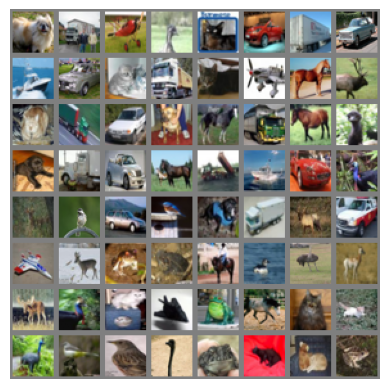

In [75]:
n_rimages = 8; n_cimages = 8 
padding = 2 
canvas = 0.5 * np.ones((n_rimages * (32 + 2 * padding), n_cimages * (32 + 2 * padding), 3))
rand_idxs = np.random.permutation(np.arange(len(train_X))[:n_rimages * n_cimages])
for r in range(n_rimages):
    for c in range(n_cimages):
        i = r * n_cimages + c
        image = train_X[rand_idxs[i]].reshape(3, 32, 32).transpose(1, 2, 0)
        temp1 = r * (32 + 2 * padding) + padding 
        temp2 = c * (32 + 2 * padding) + padding 
        canvas[temp1:temp1 + 32, temp2:temp2 + 32, :] = image
plt.imshow(canvas, vmin=0, vmax=1)
plt.axis('off');

Tiếp theo, in ra các nhãn có trong tập huấn luyện và số lượng của mỗi nhãn. Có thể thấy cả 10 nhãn trong tập huấn luyện đều có số lượng bằng nhau là 5,000 hình cho mỗi nhãn, có thể thấy số lượng mỗi nhãn đều nhau.

In [76]:
def load_meta(meta_file):
    with open(meta_file, 'rb') as f:
        meta_data = pickle.load(f, encoding='bytes')
    return meta_data[b'label_names']

# Ví dụ:
meta_file = 'cifar-10-batches-py/batches.meta'
label_names = load_meta(meta_file)

values, counts = np.unique(train_Y, return_counts=True)
for value, count in zip(values, counts):
    print(f'Value: {value} - {label_names[value].decode('utf-8')}, count: {count}')

Value: 0 - airplane, count: 5000
Value: 1 - automobile, count: 5000
Value: 2 - bird, count: 5000
Value: 3 - cat, count: 5000
Value: 4 - deer, count: 5000
Value: 5 - dog, count: 5000
Value: 6 - frog, count: 5000
Value: 7 - horse, count: 5000
Value: 8 - ship, count: 5000
Value: 9 - truck, count: 5000


Cuối cùng chính là hàm add_ones(), truyền vào ma trận X sau đó thêm cột 1 vào làm bias để hoàn thiện việc toàn xử lý. Ngoài ra có thêm hàm one_hot để encoding mảng output Y từ 0-9 về dạng one hot, để thuận tiện cho việc sử dụng các thư viện huấn luyện yêu cầu đầu vào của mảng Y phải là one hot như thư viện tensorflow.

In [77]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))

def one_hot(Y):
    K = np.max(Y) + 1
    y_onehot = np.zeros((len(Y), K))
    y_onehot[np.arange(len(Y)), Y] = 1
    return y_onehot

# Gọi hàm add_ones để tiền xử lý train_X
train_Z = add_ones(train_X)
print(f'Shape of train_Z: {train_Z.shape}')

# Gọi hàm one_hot để tiền xử lý train_Y
train_Y_onehot = one_hot(train_Y)
train_Y_onehot.shape
print(f'Shape of train_Y_onehot: {train_Y_onehot.shape}')


Shape of train_Z: (50000, 3073)
Shape of train_Y_onehot: (50000, 10)


## 2. Model Design

| Hyperparameter        | Value             |
|-----------------------|-------------------|
| Number of layers      | 2 hidden layers   |
| Neurons each layer    | 512, 512          |
| Activation function   | ReLU              |
| Optimizer             | SGD               |
| Weight decay          | 0.001             |
| Momentum              | 0                 |
| Learning rate init    | 0.1               |
| Learning rate decay   | 0.1               |
| Decay step            | 30 epochs         |
| Epochs                | 100               |
| Batch size            | 128               |
| Loss function         | Cross-entropy     |
| Validation fraction   | 0.1               |
| Early stopping        | True              |
| Stop from epoch       | 90                |

**SKLEARN**

In [78]:
def mlp_sklearn(X, y, verbose=False):
    from sklearn.neural_network import MLPClassifier
    # Số epochs cho mỗi chu kỳ
    epochs_per_cycle = 30
    total_epochs = 100
    initial_lr = 0.1
    
    # Tính số chu kỳ
    num_cycles = total_epochs // epochs_per_cycle

    # Mô hình MLPClassifier
    model = MLPClassifier(
        hidden_layer_sizes=(512, 512),
        activation='relu',
        alpha=0.001,
        solver='sgd',
        momentum=0,
        learning_rate_init=initial_lr,
        batch_size=128,
        validation_fraction=0.1,
        max_iter=epochs_per_cycle,
        n_iter_no_change=epochs_per_cycle,
        early_stopping=True,
        verbose=verbose,
        warm_start=True  # Giữ lại trạng thái mô hình khi huấn luyện thêm
    )

    # Huấn luyện mô hình với giảm learning rate sau mỗi chu kỳ
    for cycle in range(num_cycles):
        if (verbose):
            print(f"\n=== Cycle {cycle+1}/{num_cycles} ===")
        model.learning_rate_init = initial_lr * (10 ** -cycle)  # Giảm lr xuống 10 lần mỗi chu kỳ
        if (verbose):
            print(f"Learning rate: {model.learning_rate_init}")
        if cycle == num_cycles - 1:
            model.n_iter_no_change = 1
        model.fit(X, y)
    return model, {'train_loss': model.loss_curve_, 'val_loss': model.validation_scores_}

In [79]:
# Huấn luyện mô hình
model_sklearn, histor_sklearn = mlp_sklearn(train_Z, train_Y, verbose=True)


=== Cycle 1/3 ===
Learning rate: 0.1
Iteration 1, loss = 1.97597004
Validation score: 0.342200
Iteration 2, loss = 1.75340360
Validation score: 0.337400
Iteration 3, loss = 1.66524203
Validation score: 0.407200
Iteration 4, loss = 1.60128779
Validation score: 0.437000
Iteration 5, loss = 1.53911106
Validation score: 0.409200
Iteration 6, loss = 1.50315308
Validation score: 0.460400
Iteration 7, loss = 1.46405938
Validation score: 0.431000
Iteration 8, loss = 1.42835222
Validation score: 0.427200
Iteration 9, loss = 1.39286817
Validation score: 0.395400
Iteration 10, loss = 1.36195980
Validation score: 0.485800
Iteration 11, loss = 1.32983075
Validation score: 0.440800
Iteration 12, loss = 1.30864938
Validation score: 0.482600
Iteration 13, loss = 1.28332427
Validation score: 0.476400
Iteration 14, loss = 1.25128102
Validation score: 0.476200
Iteration 15, loss = 1.22943244
Validation score: 0.512400
Iteration 16, loss = 1.20021408
Validation score: 0.504400
Iteration 17, loss = 1.1807

In [80]:
# Dự đoán
test_Z = add_ones(test_X)
test_Y_pred = model_sklearn.predict(test_Z)

# Tính độ chính xác
accuracy = accuracy_score(test_Y, test_Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# In classification report
print(classification_report(test_Y, test_Y_pred, target_names=[label.decode('utf-8') for label in label_names]))

# In confusion matrix
cm = confusion_matrix(test_Y, test_Y_pred)
print(cm)

Accuracy: 55.44%
              precision    recall  f1-score   support

    airplane       0.63      0.61      0.62      1000
  automobile       0.67      0.67      0.67      1000
        bird       0.48      0.42      0.45      1000
         cat       0.39      0.37      0.38      1000
        deer       0.48      0.47      0.47      1000
         dog       0.47      0.43      0.45      1000
        frog       0.55      0.64      0.59      1000
       horse       0.61      0.63      0.62      1000
        ship       0.64      0.70      0.67      1000
       truck       0.60      0.60      0.60      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000

[[614  25  51  20  39  22  20  29 129  51]
 [ 30 670  17  21  10  12  14  24  62 140]
 [ 71  16 419  83 130  70 101  68  26  16]
 [ 25  15  76 370  65 199 120  58  32  40]
 [ 47   9 121  57 474  37 122  85  33  15]
 [ 19   8

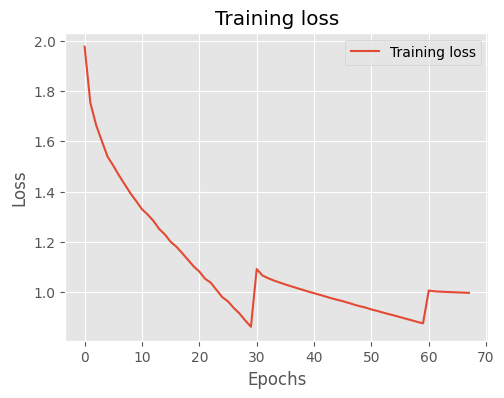

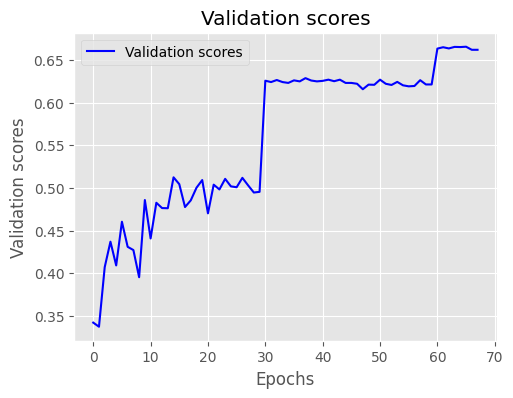

In [81]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_sklearn.loss_curve_, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_sklearn.validation_scores_, label='Validation scores', color='b')
plt.xlabel('Epochs')
plt.ylabel('Validation scores')
plt.title('Validation scores')
plt.legend()
plt.show()

**TENSORFLOW**

In [82]:
# Number of layers: 2 hidden layers
# Neuron per layer: 512
# Activation function: ReLU
# Optimizer: Adam
# Learning rate: 0.001 (default)
# Weight decay: 0.0001 
# epsilon: 1e-7 (default)
# Epochs: 100
# Batch size: 200
# Loss function: Cross-entropy

def mlp_tf(X, y, verbose=False):
    import tensorflow as tf
    from tensorflow.keras import layers, models
    model = models.Sequential([
        layers.Input(shape=(X.shape[1], )),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1,
        decay_steps=30*(X.shape[0]*0.9//128),
        decay_rate=0.1,
        staircase=True
    )

    sgd = tf.keras.optimizers.SGD(learning_rate=lr_schedule, weight_decay=0.001)

    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X, 
        one_hot(y), 
        epochs=100, 
        batch_size=128, 
        validation_split=0.1,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=0,
            min_delta=0,
            restore_best_weights=True,
            start_from_epoch=90
        )],
        verbose=verbose
    )
    return model, history

In [83]:
# Huấn luyện mô hình
model_tf, history_tf = mlp_tf(train_Z, train_Y, verbose=True)


Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.2332 - loss: 2.1072 - val_accuracy: 0.3132 - val_loss: 1.8719
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3610 - loss: 1.7813 - val_accuracy: 0.3708 - val_loss: 1.7639
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3984 - loss: 1.6827 - val_accuracy: 0.3742 - val_loss: 1.7180
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4229 - loss: 1.6241 - val_accuracy: 0.3620 - val_loss: 1.7491
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4368 - loss: 1.5792 - val_accuracy: 0.4472 - val_loss: 1.5458
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4574 - loss: 1.5252 - val_accuracy: 0.4046 - val_loss: 1.6470
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4640 - loss: 1.4926 - val_accuracy: 0.4362 - val_loss: 1.5840
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4797 - loss: 1.4661 -

In [84]:
# Dự đoán
test_Z = add_ones(test_X)
test_Y_pred = model_tf.predict(test_Z)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

# Tính độ chính xác
accuracy = accuracy_score(test_Y, test_Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# In classification report
print(classification_report(test_Y, test_Y_pred, target_names=[label.decode('utf-8') for label in label_names]))

# In confusion matrix
cm = confusion_matrix(test_Y, test_Y_pred)
print(cm)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 57.19%
              precision    recall  f1-score   support

    airplane       0.64      0.65      0.64      1000
  automobile       0.69      0.69      0.69      1000
        bird       0.48      0.46      0.47      1000
         cat       0.39      0.39      0.39      1000
        deer       0.50      0.50      0.50      1000
         dog       0.48      0.46      0.47      1000
        frog       0.59      0.64      0.62      1000
       horse       0.63      0.63      0.63      1000
        ship       0.68      0.69      0.69      1000
       truck       0.62      0.61      0.62      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000

[[646  34  48  17  39  15  23  20 109  49]
 [ 31 686  12  17   8  15  11  22  56 142]
 [ 69   9 460  88 130  72  83  57  14  18]
 [ 29  18  88 392  59 194 104  58  24  34]
 [ 45  11 1

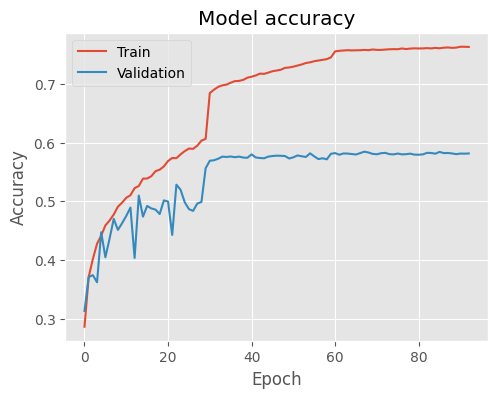

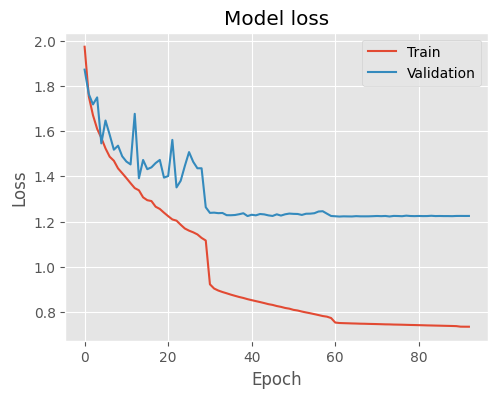

In [85]:
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_tf.history['accuracy'], label='Train')
plt.plot(history_tf.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history_tf.history['loss'], label='Train')
plt.plot(history_tf.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**PYTORCH**

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class MLP(nn.Module):
    def __init__(self, input_size, ouput_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, ouput_size),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

def mlp_pytorch(X, y, verbose=False):
    epochs = 100
    batch_size = 128
    patience = 0
    start_from_epoch = 90


    # Convert data to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss, and optimizer
    input_size = X.shape[1]
    output_size = 10
    model = MLP(input_size, output_size)

    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1, verbose=True)

    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "val_accuracy": []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)
        
        # Early stopping
        if epoch >= start_from_epoch:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_model.pth")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        
        # Update learning rate
        lr_scheduler.step()
        if (verbose):
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
                f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Load the best model
    model.load_state_dict(torch.load("best_model.pth"))
    
    return model, history


# Dự đoán
def pytorch_predict(model, test_X):
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    with torch.no_grad():  # Tắt tính toán gradient
        # Thêm cột 1s (nếu cần)
        test_Z = torch.tensor(test_X, dtype=torch.float32)  # Convert test_X to PyTorch tensor
        
        # Dự đoán xác suất
        outputs = model(test_Z)
        
        # Lấy nhãn dự đoán (argmax trên xác suất)
        test_Y_pred = outputs.argmax(dim=1).numpy()  # Chuyển về numpy array
    return test_Y_pred 


In [87]:
# Huấn luyện mô hình
model_pytorch, hystory_pytorch = mlp_pytorch(train_Z, train_Y, verbose=True)

Epoch 1/100, Train Loss: 1.9993, Val Loss: 2.0082, Val Accuracy: 0.2832, Learning Rate: 0.100000
Epoch 2/100, Train Loss: 1.8052, Val Loss: 1.7127, Val Accuracy: 0.3844, Learning Rate: 0.100000
Epoch 3/100, Train Loss: 1.7149, Val Loss: 1.7017, Val Accuracy: 0.3852, Learning Rate: 0.100000
Epoch 4/100, Train Loss: 1.6592, Val Loss: 1.7199, Val Accuracy: 0.3862, Learning Rate: 0.100000
Epoch 5/100, Train Loss: 1.6101, Val Loss: 1.6391, Val Accuracy: 0.4082, Learning Rate: 0.100000
Epoch 6/100, Train Loss: 1.5713, Val Loss: 1.8270, Val Accuracy: 0.3710, Learning Rate: 0.100000
Epoch 7/100, Train Loss: 1.5391, Val Loss: 1.5332, Val Accuracy: 0.4544, Learning Rate: 0.100000
Epoch 8/100, Train Loss: 1.5062, Val Loss: 1.5330, Val Accuracy: 0.4452, Learning Rate: 0.100000
Epoch 9/100, Train Loss: 1.4768, Val Loss: 1.6359, Val Accuracy: 0.4138, Learning Rate: 0.100000
Epoch 10/100, Train Loss: 1.4606, Val Loss: 1.5294, Val Accuracy: 0.4502, Learning Rate: 0.100000
Epoch 11/100, Train Loss: 1.4

In [89]:
# Dự đoán
test_Z = add_ones(test_X)
test_Y_pred = pytorch_predict(model_pytorch, test_Z)

# Tính độ chính xác
accuracy = accuracy_score(test_Y, test_Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# In classification report
print(classification_report(test_Y, test_Y_pred, target_names=[label.decode('utf-8') for label in label_names]))

# In confusion matrix
cm = confusion_matrix(test_Y, test_Y_pred)
print(cm)


Accuracy: 57.46%
              precision    recall  f1-score   support

    airplane       0.64      0.65      0.64      1000
  automobile       0.69      0.68      0.69      1000
        bird       0.49      0.46      0.47      1000
         cat       0.39      0.38      0.39      1000
        deer       0.50      0.49      0.50      1000
         dog       0.50      0.46      0.48      1000
        frog       0.59      0.66      0.62      1000
       horse       0.65      0.64      0.64      1000
        ship       0.67      0.71      0.69      1000
       truck       0.61      0.61      0.61      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000

[[647  31  46  20  31  16  23  20 115  51]
 [ 26 682  17  16  10  15  11  15  64 144]
 [ 69  12 461  88 127  63  83  54  19  24]
 [ 29  16  85 383  64 202 111  50  25  35]
 [ 45   7 130  60 494  37 106  79  30  12]
 [ 17   3

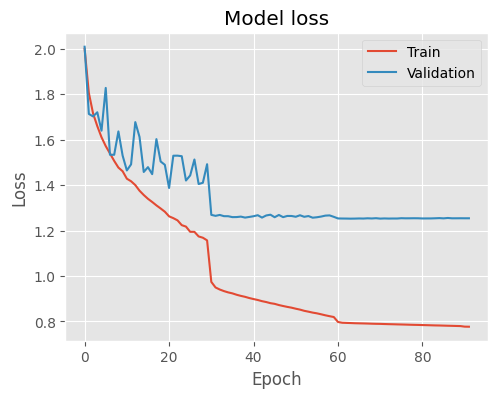

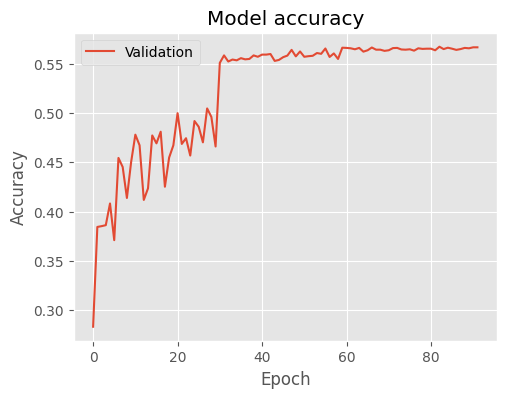

In [90]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hystory_pytorch['train_loss'], label='Train')
plt.plot(hystory_pytorch['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(hystory_pytorch['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Evaluation

In [ ]:
import torch
import tensorflow as tf
import time
import psutil
import tracemalloc

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

train_function = {
    'sklearn': mlp_sklearn,
    'tf': mlp_tf,
    'pytorch': mlp_pytorch,
}

model = []
history = []
time_measure = []
memory_measure = []

for key, value in train_function.items():
    print(f"Training with {key}")
    start = time.time()

    # Đo memory usage
    tracemalloc.start()

    # Huấn luyện model
    model_, history_ = value(train_Z, train_Y)

    # Đo memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Đo thời gian và GPU usage
    end = time.time()
    model.append(model_)
    history.append(history_)
    time_measure.append((end - start) / 60)
    memory_measure.append(current / 10**6)

    print(f"{key} - Time: {(end - start) / 60:.2f} min, Memory Usage: {memory_measure[-1]:.2f} MB")
    print()


In [ ]:
test_Z = add_ones(test_X)

accuracy = []
model_confusion_matrix = []
model_classification_report = []

model_predict = {
    'sklearn': model[0].predict(test_Z),
    'tf': model[1].predict(test_Z),
    'pytorch': pytorch_predict(model[2], test_Z),
}


for key, predict_ in model_predict.items():
    if key == 'tf':
        predict_ = np.argmax(predict_, axis=1)
    accuracy_ = accuracy_score(test_Y, predict_)
    confusion_matrix_ = confusion_matrix(test_Y, predict_)
    classification_report_ = classification_report(test_Y, predict_, target_names=[label.decode('utf-8') for label in label_names])

    accuracy.append(accuracy_)
    model_confusion_matrix.append(confusion_matrix_)
    model_classification_report.append(classification_report_)

    print("====================================")
    print(f"Accuracy of {key}: {accuracy_ * 100:.2f}%")
    print(f"Confusion matrix of {key}:")
    print(confusion_matrix_)
    print(f"Classification report of {key}:")
    print(classification_report_)
    print()
    


### Time measure

In [ ]:
# Plot time of each library
plt.figure(figsize=(12, 4))
bars = plt.bar(train_function.keys(), time_measure)
plt.bar_label(bars)
plt.ylabel('Time (minutes)')
plt.title('Training time')
plt.show()

### Memory usage

In [ ]:
# Plot memory usage of each library
plt.figure(figsize=(12, 4))
bars = plt.bar(train_function.keys(), memory_measure)
plt.bar_label(bars, fmt='%.0f', label_type='edge')  
plt.ylabel('Memory (MB)')
plt.title('Memory usage')
plt.show()


### Accuracy

In [ ]:
plt.figure(figsize=(12, 4))
bars = plt.bar(train_function.keys(), accuracy)
plt.bar_label(bars, fmt='%.2f', label_type='edge')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

### Combine

In [ ]:
accuracy_percent = [a * 100 for a in accuracy]

# Vẽ biểu đồ
n = len(train_function)
index = np.arange(n)
width = 0.25  # Độ rộng của mỗi cột

plt.figure(figsize=(12, 6))

bars1 = plt.bar(index - width, time_measure, width, label='Time (minutes)')
bars2 = plt.bar(index, memory_measure, width, label='Memory (MB)')
bars3 = plt.bar(index + width, accuracy_percent, width, label='Accuracy (%)')

# Hiển thị giá trị trên cột
plt.bar_label(bars1, fmt='%.0f')
plt.bar_label(bars2, fmt='%.0f')
plt.bar_label(bars3, fmt='%.2f')

# Thiết lập trục và tiêu đề
plt.xticks(index, train_function)
plt.ylabel('Values')
plt.title('Comparison of Time, Memory, and Accuracy')
plt.legend()

### Training loss

In [ ]:

sklearn_loss = model[0].loss_curve_
tf_loss = history[1].history['loss']
pytorch_loss = history[2]['train_loss']

plt.figure(figsize=(12, 4))
plt.plot(sklearn_loss, label='Sklearn', color='r')
plt.plot(tf_loss, label='Tensorflow', color='g')
plt.plot(pytorch_loss, label='Pytorch', color='b')
plt.title('Training loss')
plt.legend()
plt.show()

### Validation scores

In [ ]:
sk_learn_val_loss = model[0].validation_scores_
tf_val_loss = history[1].history['val_accuracy']
pytorch_val_loss = history[2]['val_accuracy']

plt.figure(figsize=(12, 4))
plt.plot(sk_learn_val_loss, label='Sklearn', color='r')
plt.plot(tf_val_loss, label='Tensorflow', color='g')
plt.plot(pytorch_val_loss, label='Pytorch', color='b')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


### Confusion matrix

In [ ]:
# Draw heatmap of confusion matrix
for (key, cm) in enumerate(zip(train_function.keys(), model_confusion_matrix)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[name.decode('utf-8') for name in label_names], yticklabels=[name.decode('utf-8') for name in label_names])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix of {key}')
    plt.show()
